In [1]:
import warnings
import itertools
import sys
import json
from math import sqrt

import pandas as pd
import numpy as np
from alpha_vantage.timeseries import TimeSeries

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
class AlphaVantageInfo:
    base_url = "https://www.alphavantage.co/query?"
    api_key = "1PRBO66RYM7SV7B9"


class JSONLoader:
    @staticmethod
    def save_json(company_name, data, label=""):
        filename = f'./demo/{company_name}_{label}.json' if label \
            else f'./demo/{company_name}.json'
        with open(filename, 'w') as outfile:
            json.dump(data, outfile)

    @staticmethod
    def load_json(filename):
        with open(filename, 'r') as infile:
            data, metadata = json.load(infile)
            return data, metadata

    pass

In [3]:
ibm_data, ibm_metadata = JSONLoader.load_json("IBM_daily_adjusted.json")

In [4]:
ibm_df = pd.DataFrame.from_dict(ibm_data, orient='index').astype('float')
ibm_df = ibm_df.reindex(index=ibm_df.index[::-1])
ibm_df.index = pd.to_datetime(ibm_df.index)
ibm_df = ibm_df.asfreq(freq="B")

In [5]:
y = ibm_df['5. adjusted close'][:]

In [6]:
ibm_df.shape

(5580, 8)

In [7]:
# plt.figure(figsize=(15, 6))
# plt.plot(y)

# plt.title('Daily Time Series: IBM')
# plt.xticks(rotation=90)
# plt.grid()
# plt.show()

In [8]:
# num_params = 4
# p = [1, 2, 4, 6, 8]
# d = range(0, 3)
# q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [9]:
# search_vals = []
# for param in pdq: 
#     for param_s in seasonal_pdq: 
#         try: 
#             train, test = y[0:int(y.shape[0]/3)], y[int(y.shape[0]/3):]
#             mod = sm.tsa.statespace.SARIMAX(train,
#                                                 order=param,
#                                                 seasonal_order=param_s,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False)
#             results = mod.fit()
#             pred = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
#             # rmse = -1
#             # rmse = sqrt(mean_squared_error(y.values, pred.predicted_mean))
#             rmse = np.sqrt(np.nanmean((test.values - pred.predicted_mean.values)**2))
#             # import pdb; pdb.set_trace()
#             print(f'SARIMAX{param}*{param_s} - AIC: {results.aic} - RMSE: {rmse}')
#             search_vals.append([param, param_s, pred, rmse])
            
#             del mod 
#             del results
#         except Exception as e: 
#             print(f'{e} at {param}, {param_s}')
#             continue

In [10]:
mod = sm.tsa.statespace.SARIMAX(y[0:int(y.shape[0]/3)],
                                order=(2, 2, 1),
                                seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

/home/jjmoey/capstone-project-3900-w18a-to-the-moon/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                       5. adjusted close   No. Observations:                 1860
Model:             SARIMAX(2, 2, 1)x(4, 1, [1, 2], 12)   Log Likelihood               -2783.712
Date:                                 Thu, 25 Mar 2021   AIC                           5587.424
Time:                                         22:56:45   BIC                           5642.357
Sample:                                     11-01-1999   HQIC                          5607.704
                                          - 12-15-2006                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0767      0.017     -4.597      0.000      -0.109      -0

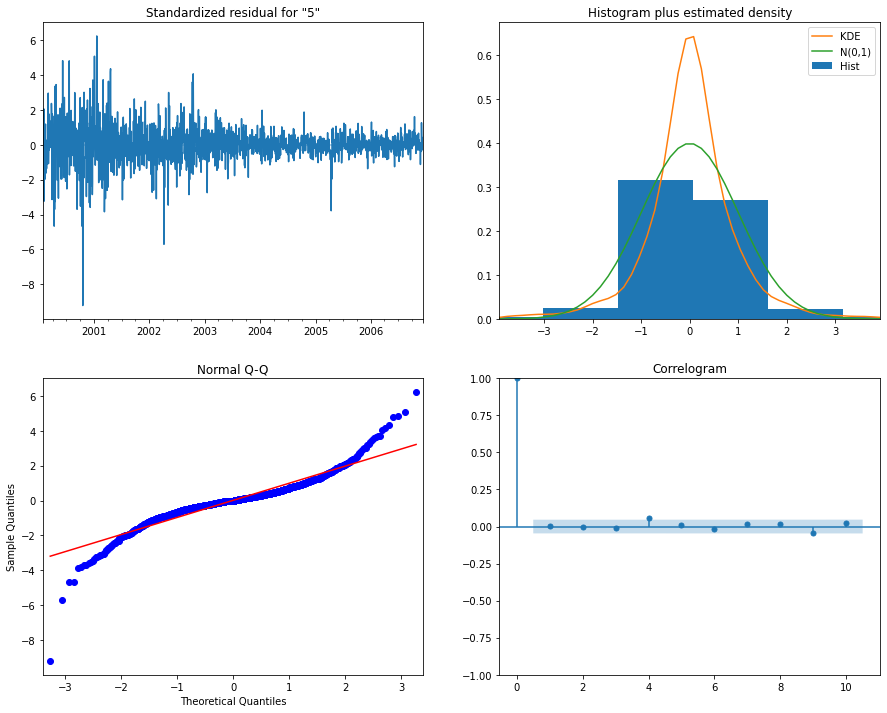

In [11]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [12]:
pred = results.get_prediction(start=0, dynamic=False)
pred_ci = pred.conf_int()

In [13]:
rmse = np.sqrt(np.nanmean((y.values[0:int(y.shape[0]/3)] - pred.predicted_mean.values)**2))
print(rmse)

2.3376574160617762


In [14]:
fore = results.get_prediction(start=pd.to_datetime("2000-03-22"), end=pd.to_datetime("2021-12-24"), dynamic=False)

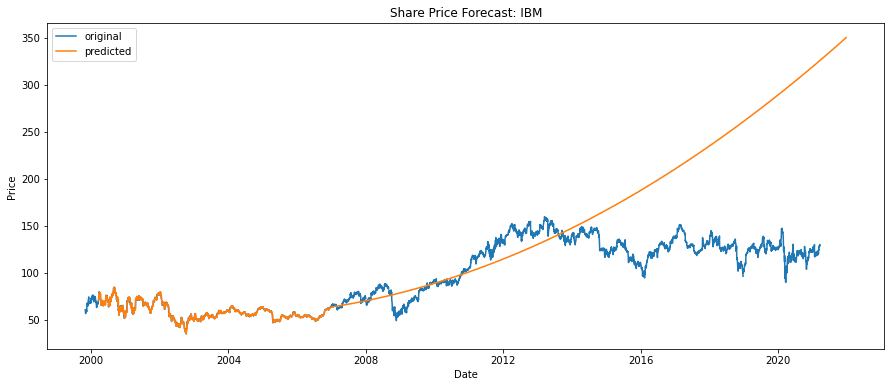

In [15]:
fig = plt.figure(figsize=(15, 6))

plt.plot(y[:], label="original")
# plt.plot(pred.predicted_mean[-500:], label="predicted")
plt.plot(fore.predicted_mean, label="predicted")

# plt.fill_between(pred_ci.index[-1000:],
#                 pred_ci.iloc[:, 0][-1000:],
#                 pred_ci.iloc[:, 1][-1000:], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Share Price Forecast: IBM')
plt.legend()

plt.show()

In [16]:
results.save("bruz.pickle")